# **코사인 유사도**

**Numpy를 이용하여 코사인 유사도 함수 구현**

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2)))
    similarity = dot_product / l2_norm
    return similarity

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
feature_vect_simple.shape

(3, 18)

In [4]:
feature_vect_dense = feature_vect_simple.todense()

vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )

similarity_simple = cos_similarity(vect1, vect2)
print(f'문장 1, 문장 2 의 Cosine 유사도: {similarity_simple:.3f}')
similarity_simple = cos_similarity(vect1, vect3)
print(f'문장 1, 문장 3 의 Cosine 유사도: {similarity_simple:.3f}')
similarity_simple = cos_similarity(vect2, vect3)
print(f'문장 2, 문장 3 의 Cosine 유사도: {similarity_simple:.3f}')

문장 1, 문장 2 의 Cosine 유사도: 0.402
문장 1, 문장 3 의 Cosine 유사도: 0.404
문장 2, 문장 3 의 Cosine 유사도: 0.456


**사이킷런의 코사인 유사도 함수**

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]


# **문서 유사도 측정 - Opinion Review 데이터 세트**

In [9]:
import pandas as pd
import glob, os
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 700)

path = r'/content/drive/MyDrive/독학/Python ML/data/topics'
all_files = glob.glob(os.path.join(path, '*.data'))
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,location_holiday_inn_london,"Great location for tube and we crammed in a fair amount of sightseeing in a short time .\n0 All in all, a normal chain hotel on a nice lo..."
1,room_holiday_inn_london,"We arrived at 23,30 hours and they could not recommend a restaurant so we decided to go to Tesco, with very limited choices but when you are hingry you do not careNext day they rang the bell at 8,00 hours to clean the room, not being very nice being waken up so earlyEvery day they gave u..."
2,seats_honda_accord_2008,"Front seats are very uncomfortable .\n0 No memory seats, no trip computer, can only display outside temp with trip odometer .\n1 ..."
3,staff_swissotel_chicago,"The staff at Swissotel were not particularly nice .\n0 Each time I waited at the counter for staff for several minutes and then was waved to the desk upon my turn with no hello or anything, or apology for waiting in line .\n1 ..."
4,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and very comfortable beds, a great shower and very clean bathrooms .\n0 The second room was smaller, with a very inconvenient bathroom layout, but at least it was quieter and we were able to sleep .\n1 ..."


In [10]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환.
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환.
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=1000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

document_df['cluster_label'] = cluster_label

In [19]:
#군집화 결과 중 호텔로 군집화된 문서(cluster_label=2)로 코사인 유사도 측정
from sklearn.metrics.pairwise import cosine_similarity

hotel_indexes = document_df[document_df['cluster_label']==2].index
print('호텔로 군집화된 문서들의 DataFrame Index:', hotel_indexes)

#호텔로 군집화된 문서 중 첫번째 문서를 추출
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명', comparison_docname, '과 타 문서 유사도 #####')

#호텔로 군집화된 문서 중 첫번째 문서와 다른 문서 간의 코사인 유사도 측정
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화된 문서들의 DataFrame Index: Index([0, 1, 3, 4, 7, 8, 11, 21, 22, 24, 26, 30, 38, 40, 46, 50], dtype='int64')
##### 비교 기준 문서명 location_holiday_inn_london 과 타 문서 유사도 #####
[[1.         0.19916545 0.14355043 0.06193142 0.08207945 0.22310248
  0.30960169 0.18388376 0.09157659 0.07180853 0.66967861 0.23538161
  0.21979121 0.43230491 0.19635109 0.16725814]]


가장 유사도가 큰 파일명 및 유사도:
 filename      location_bestwestern_hotel_sfo
similarity                          0.669679
Name: 26, dtype: object


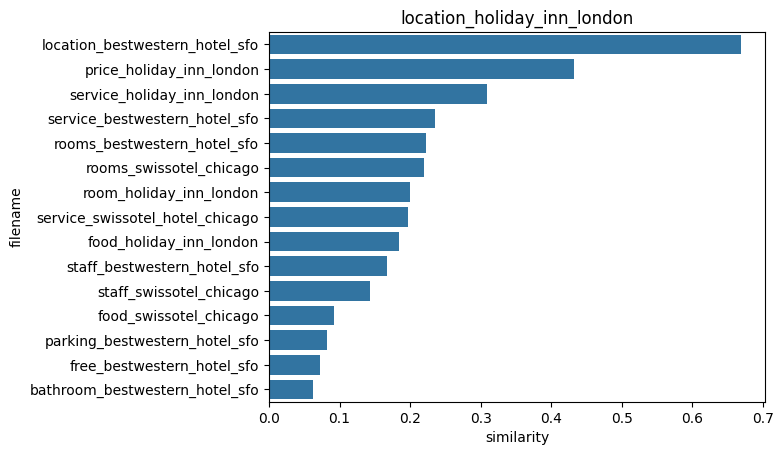

In [24]:
#코사인 유사도 시각화
import seaborn as sns
import matplotlib.pyplot as plt

sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:,1:]

hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value
print('가장 유사도가 큰 파일명 및 유사도:\n', hotel_1_sim_df.iloc[0,:])

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)
plt.show()